### Pill 14 WIKI Side Quest: Mixture of Gaussians ###

Create an artificial data set the breaks the assumtions of Mixture of Gaussians as computed in class. Report and comment this. Highlight how one could handle the proposed datas set.

We have chosen noisy parabolas forming a star to break the assumptions of Mixture of Gaussians. In this case 4 classes have been created each one generated throughout a noisy parabola with a 0, 90, 180 and 270 degrees rotation and an expanded translation of the points.

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import pi, cos, sin
from scipy.spatial.distance import cdist

def parabola(angle,t1,t2):
    x = 6*np.random.random()*np.sign(np.random.normal())
    y = 0.15*x**2 + .3*np.random.normal()
    p = np.array([x,y])  
    
    piangle = angle*pi/180
    rot = np.array([[cos(piangle), -sin(piangle)], [sin(piangle), cos(piangle)]])
    
    return np.dot(rot, p.T) + np.array([t1,t2])

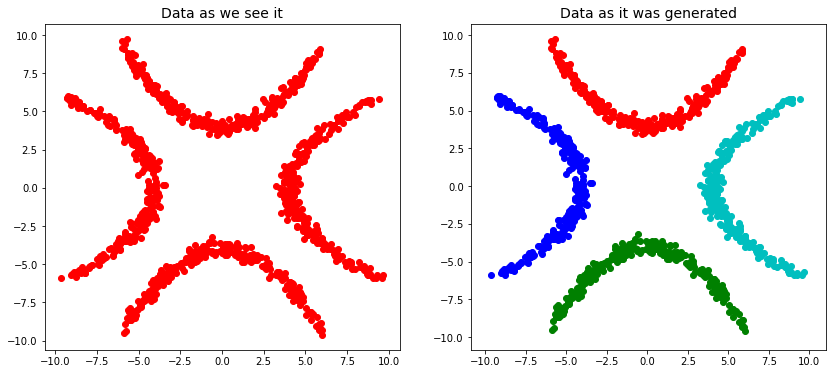

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#Create some data
MAXN=250
X = np.array([parabola(0,0,4) for _ in range(MAXN)]) 
X = np.concatenate([X,np.array([parabola(90,-4,0) for _ in range(MAXN)])])
X = np.concatenate([X,np.array([parabola(180,0,-4) for _ in range(MAXN)])])
X = np.concatenate([X,np.array([parabola(270,4,0) for _ in range(MAXN)])])
#Just for visualization purposes
y = np.concatenate([np.ones((MAXN,1))])
y = np.concatenate([y,2*np.ones((MAXN,1))])
y = np.concatenate([y,3*np.ones((MAXN,1))])
y = np.concatenate([y,4*np.ones((MAXN,1))])

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.title('Data as we see it', size=14)

plt.subplot(1,2,2)
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='g')
plt.scatter(X[(y==4).ravel(),0],X[(y==4).ravel(),1],color='c')

plt.title('Data as it was generated',size=14)
fig=plt.gcf()
fig.set_size_inches((14,6))

Here we can see that the accumulation of the points coincides where the branches of different parabolas are close each other and the localization of the different classes might be difficult by the Mixture of Gaussians.

[[ 0.35301475  0.19156356]
 [-0.63171681 -0.52725675]
 [-0.53014178 -0.27131107]
 [ 0.60888877 -0.64447718]]


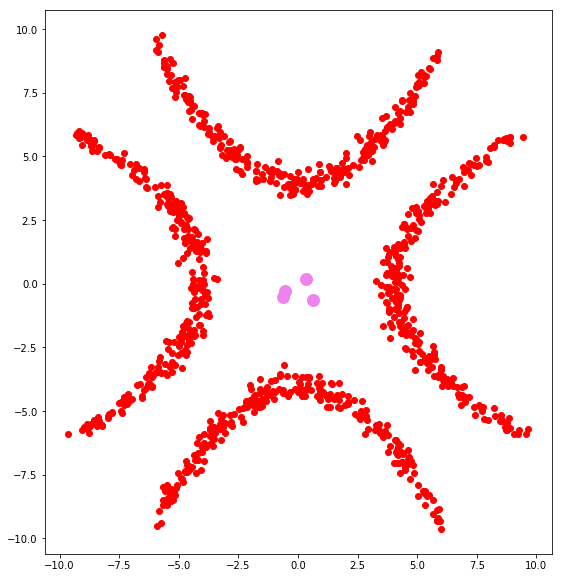

In [22]:
K = 4
idx=np.random.randint(0,X.shape[0],K)
C=2*np.random.rand(K,X.shape[1])-1
Sigma=100.*np.ones((K,X.shape[1]))
Pi=(1./K)*np.ones((K,1))
print (C)

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='violet', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((20,10))

[[4.19034612 1.15827708]
 [3.85889691 1.60505994]
 [1.44818512 3.59360343]
 [1.20999588 4.45033704]] [[0.22321627]
 [0.27554594]
 [0.23865554]
 [0.26258225]]


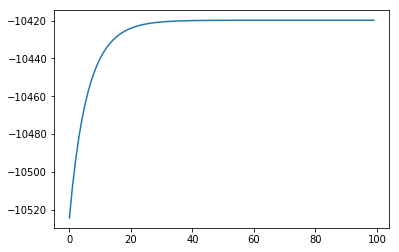

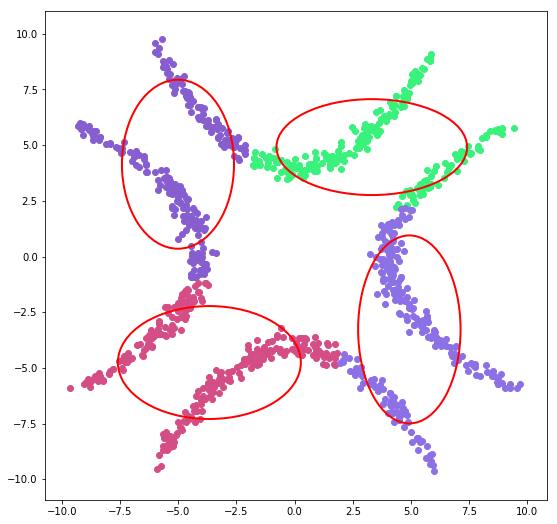

In [24]:
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist

def define_responsibilities(X,C,Sigma,Pi):
    r = np.zeros((X.shape[0],C.shape[0]))
    for i in range(C.shape[0]):
        d = cdist(C[i,:][np.newaxis,:],X,metric='seuclidean',V=Sigma[i,:])**2
        r[:,i]=Pi[i]*np.exp(-0.5*d)/np.prod(np.sqrt(2*np.pi)*Sigma[i,:])
    r = r/np.tile(np.sum(r,axis=1)[:,np.newaxis],(1,C.shape[0]))
    return r

def soft_kmeans2_iter(X,C,Sigma,Pi):
    I=X.shape[1]
    r = define_responsibilities(X,C,Sigma,Pi)
    for k in range(C.shape[0]):
        C[k,:]=np.sum((np.tile(r[:,k][:,np.newaxis],(1,C.shape[1]))*X),axis=0)/np.sum(r[:,k])
        Sigma[k,:]= np.sum(np.tile(r[:,k][:,np.newaxis],(1,C.shape[1]))*(X-np.tile(C[k,:][np.newaxis,:],(X.shape[0],1)))**2,axis=0)/(I*np.sum(r[:,k]))
        Pi[k]=np.sum(r[:,k])/np.sum(r) 
    return C,Sigma,Pi

def evaluate_objective(X,C,Sigma,Pi):
    J=0
    for k in range(C.shape[1]):
        J += Pi[k]*multivariate_normal.pdf(X, mean=C[k,:], cov=Sigma[k,:])
    return np.sum(np.log(J))
    
conv=[]
for iter in range(100):
    conv.append(evaluate_objective(X,C,Sigma,Pi))
    C,Sigma,Pi = soft_kmeans2_iter(X,C,Sigma,Pi)
print (Sigma,Pi)

plt.figure()
plt.plot(conv)
plt.figure()
r = define_responsibilities(X,C,Sigma,Pi)
y_pred = np.argmax(r,axis=1)
for label in np.unique(y_pred):
    plt.scatter(X[(y_pred==label).ravel(),0],X[(y_pred==label).ravel(),1],color=[np.random.rand(),np.random.rand(),np.random.rand()])

    
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='none', 
           linewidths=2,
           zorder=10)

from matplotlib.patches import Ellipse
ax = plt.gca()
ellipse = Ellipse(xy=C[0,:], width=4*np.sqrt(Sigma[0,0]), height=4*np.sqrt(Sigma[0,1]), 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)

ellipse = Ellipse(xy=C[1,:], width=4*np.sqrt(Sigma[1,0]), height=4*np.sqrt(Sigma[1,1]), 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)

ellipse = Ellipse(xy=C[2,:], width=4*np.sqrt(Sigma[2,0]), height=4*np.sqrt(Sigma[2,1]), 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)

ellipse = Ellipse(xy=C[3,:], width=4*np.sqrt(Sigma[3,0]), height=4*np.sqrt(Sigma[3,1]), 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)


fig = plt.gcf()
fig.set_size_inches((9,9))

As we can see this methodology does not catch the differences between classes at all. Indeed, it considers that the data is created by 4 Gaussians composed by the combination of the closest branches of the different parabolas. 